# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd
from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

Using TensorFlow backend


2023-11-18 23:35:31.030929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 23:35:31.068480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 23:35:31.068514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 23:35:31.068550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 23:35:31.076402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 23:35:31.076868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/draco/work/quijote/"

## Loading the Data

I am trying to have a single dataframe with all the normalised parameters and the powerspectrums. There are 2k rows for the 2k Latin hypercube simulations. The frist five columns represent the normalised 5 Vanilla $\Lambda CDM$ model - $\Omega_m$,$\Omega_b$, $h$,$n_s$,$\sigma_8$respectively and the next columns are the values of the matter power spectrum at different scales.

In [4]:
# Reading the data

pk = pd.read_csv(directory_path+"Pk_lh.csv")[:32].T                      # taking transpose to keep in check the dimensionality
pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

#normalising the parameters
mean_params = params.mean(axis=0).values
std_params = params.std(axis = 0).values
norm_params = (params - mean_params)/std_params

# Concatenating the params and pk

df = pd.concat([norm_params,pk],axis = 1)


P_k = df[df.columns[5:]]
van_labels = df[df.columns[:5]]


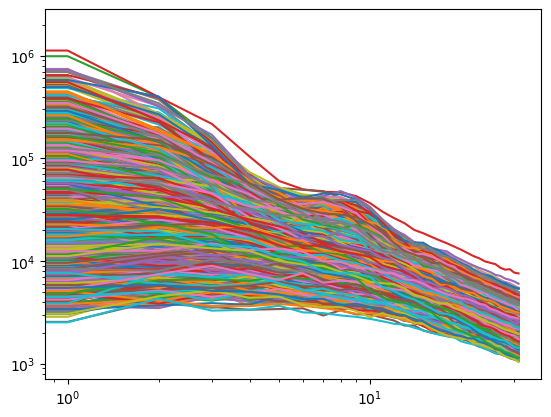

In [5]:
plt.plot(P_k.T)

plt.loglog()
plt.show()

The first 5 columns of our data set $("df")$ are the labels which are the the normalised 5 Vanilla $\Lambda CDM$ model and the rest are the Power spectrum values $P_{K}$. Now, we split the data into training set, validation set and test set. Here, I am permuting the dataset to avoid any bias.

In [6]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    # Permuting the DataFrame.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
y_train


,Omega_m,Omega_b,h,n_s,sigma_8
674,1.602612,-0.194807,-0.785289,0.778362,-1.017326
1699,-1.212998,0.894381,-1.088322,-0.946329,-1.038105
1282,-1.318627,-0.847627,1.225120,-1.510837,-1.235509
1315,-0.684855,0.125542,0.580958,-1.391355,0.778362
1210,0.125542,-1.209535,-1.315164,-1.124686,-0.665807
...,...,...,...,...,...
752,0.341995,-0.535936,-1.384429,0.071862,0.109958
121,-0.397406,-0.049351,0.863212,-0.468403,0.709098
699,-0.037230,1.476204,-1.536811,0.790484,0.052814
876,0.683123,-0.504767,1.076201,1.226851,0.378359


# Define couple of useful functions

#### Defining the loss plot function

In [28]:
# Function defining loss plot.

def plot_loss(histories, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(histories.index, df_history['loss'], label='Training_loss')
    plt.plot(histories.index, df_history['val_loss'], label='Validation_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

In [29]:
# #Split the available dataset in the train validation and test set

# def train_val_test_split(
#         properties,
#         labels,
#         val_fraction = 0.2,
#         test_fraction = 0.2,
#         random_state=1,
# ):
#     test_size = round(len(properties) * test_fraction)
#     val_size = round(len(properties) * val_fraction)

#     train_prop, test_prop, train_lab, test_lab = _train_test_split(
#           properties, labels, 
#           test_size=test_size, random_state=random_state)

#     train_prop, val_prop, train_lab, val_lab = _train_test_split(
#           train_prop, train_lab,
#           test_size=val_size, random_state=random_state)
    
#     return train_prop, val_prop, test_prop, train_lab, val_lab, test_lab

#### LaTex Label Names

In [30]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

#### Defining Elu+1 activation function
Used for positive definitness of the sigma outputs.

In [31]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

# Analysis

Creating Layers

In [32]:
# training_set_properties = X_train #data_LH_vanilla["P0"]["train"]["ftr"]

# defining elu+1 before as it is used below. not sure why? - elu gives a negative output however for the sigma values we need a positive definitness so we elu+1 helps with that but i dont know how to implement it

def elu_plus_one(x):
    return (tf.keras.activations.elu(x)+1)

def create_layers(architecture, dropout_rate):

    # the features are normalized to have mean=0 and std=1
    inputs = Input(shape=X_train.shape[1])
    normalize_layer = layers.Normalization()
    normalize_layer.adapt(X_train)
    norm_inputs = normalize_layer(inputs)
    input_layer = norm_inputs

# Adding hidden dense layers which is specified by the architecture in our case its 3 layers with 32 neurons each
  

    for n_nodes in architecture:
        d_layer = layers.Dense(n_nodes,
                              activation="selu",
                              kernel_initializer="he_normal",)(input_layer)

        
# Each followed by a dropout layer  to apply dropout regularisation to the o/p of the d_layer which is then assigned to the input_layer for the next iteration which is the two dense layer mean and sigma our output layers
        
        
        input_layer = layers.Dropout(dropout_rate)(d_layer)


# Add the output layer combining means and sigmas
   
    
    means = layers.Dense(
        5,
        activation="linear",
        kernel_initializer="he_normal",
    )(input_layer)

    sigmas = layers.Dense(
        5, 
        activation="elu_plus_one", # ????is there any particular reason for using elu+1? - yes as it is an exponential function so doest return 0 for a negative function.
        kernel_initializer="he_normal",
    )(input_layer)

    output_layer = layers.Concatenate()([means, sigmas])
    
    return inputs, output_layer

Define loss

In [33]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    y_true = tf.cast(y_true, dtype=y_pred.dtype) #????? 
    
    squared_differences = tf.math.square(y_true - means_pred)
    sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)

    return loss

Create model

In [34]:
def create_model(inputs, output_layer):
    model = Model(inputs=inputs, outputs=output_layer)

    model.compile(
        loss=mse_means_and_sigmas_uncorrelated,
        optimizer=tf.optimizers.Adam(learning_rate=1.e-5),
        #optimizer=tf.optimizers.Adam(learning_rate=1.e-3),
    )

    model.summary()
    
    return model

Define callbacks

In [35]:
# Definfing callbacks using cyclic learning rate in our case

max_lr = 1.e-3
clr_triangular = CLR.CyclicLR(#mode='exp_range',
                              base_lr=max_lr/4.,
                              max_lr=max_lr,
                              step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                              gamma=0.99994)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
    restore_best_weights=True,
    verbose=0,
)

Define some ancillary stuff

In [36]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

Fit

In [42]:
# Neural Network Model

inputs, output_layer = create_layers([128, 128, 128], 0.1)
model = create_model(inputs, output_layer)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 normalization_4 (Normaliza  (None, 32)                   65        ['input_5[0][0]']             
 tion)                                                                                            
                                                                                                  
 dense_20 (Dense)            (None, 128)                  4224      ['normalization_4[0][0]']     
                                                                                                  
 dropout_12 (Dropout)        (None, 128)                  0         ['dense_20[0][0]']      

In [43]:
# Fitting the model

histories= model.fit(
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    batch_size=512,
    epochs=1000000,
    callbacks=[clr_triangular, early_stopping],
    verbose=0,
)
# Histories return 
df_history = pd.DataFrame(histories.history)
df_history

,loss,val_loss
0,6.598656,2.400803
1,4.862586,0.928747
2,4.185404,0.867426
3,3.996952,0.378617
4,3.756081,0.129564
...,...,...
1052,-5.205534,-5.885370
1053,-5.300778,-5.853413
1054,-5.220971,-5.897182
1055,-5.206561,-5.920179


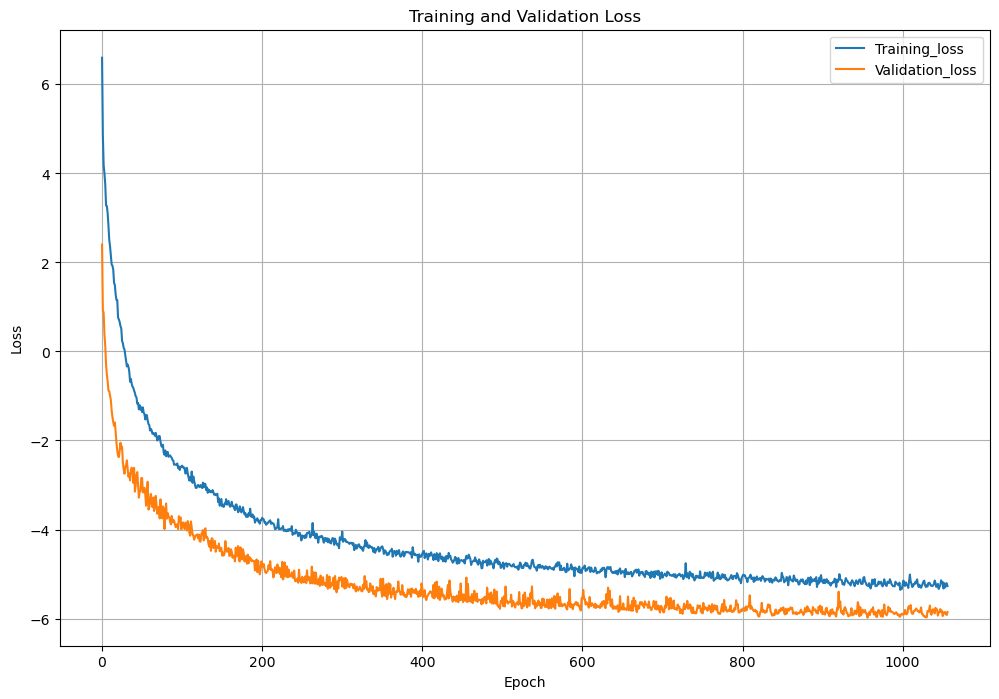

In [44]:
plot_loss(df_history)#, logy=True, ylim=[15, 25])

In [45]:
# prediction of parameters

predictions = model.predict(X_test, verbose=0)
df_predictions = pd.DataFrame(predictions)
y_mean_predict = df_predictions[df_predictions.columns[:5]]
y_sigma_predict = df_predictions[df_predictions.columns[5:]]


df_predictions


,0,1,2,3,4,5,6,7,8,9
0,-0.909065,1.026865,-0.851095,0.887084,0.273966,0.161260,0.574798,0.461253,0.582772,0.059197
1,1.019616,0.008247,0.582806,0.352342,-0.084429,0.276398,0.707824,0.746014,0.707963,0.049804
2,0.711653,0.020346,-0.359611,-0.234264,1.127424,0.291071,0.807461,0.869828,0.828220,0.061474
3,0.520222,-0.437337,0.285051,0.223461,-1.215020,0.331305,0.801326,0.849397,0.770108,0.065705
4,0.234672,-0.450692,0.018039,-0.528641,-1.589364,0.303658,0.753835,0.905281,0.809692,0.065317
...,...,...,...,...,...,...,...,...,...,...
395,0.778322,0.447901,-0.044255,0.462704,-1.441328,0.282765,0.694816,0.724268,0.754927,0.071392
396,0.973095,-0.550363,0.616631,0.295133,1.086525,0.291120,0.759639,0.752377,0.796538,0.067138
397,1.772322,0.746243,0.370273,0.959252,0.709541,0.245615,0.791827,0.603191,0.665674,0.058160
398,0.956338,0.270553,-0.673723,-0.354598,-1.312821,0.330446,0.836190,0.805815,0.753691,0.075447


/tmp/ipykernel_479161/334802014.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


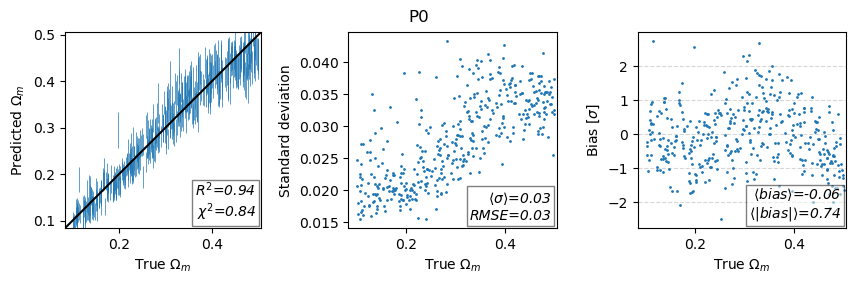

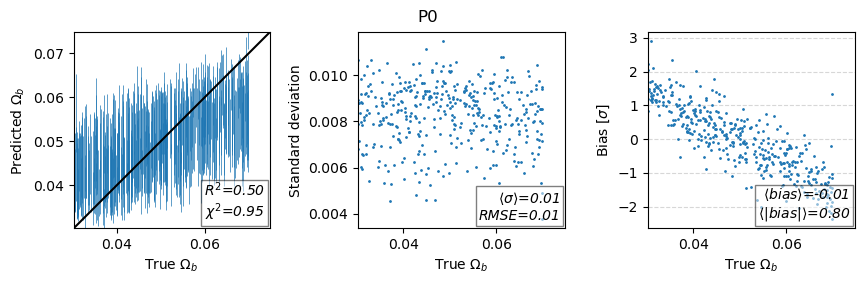

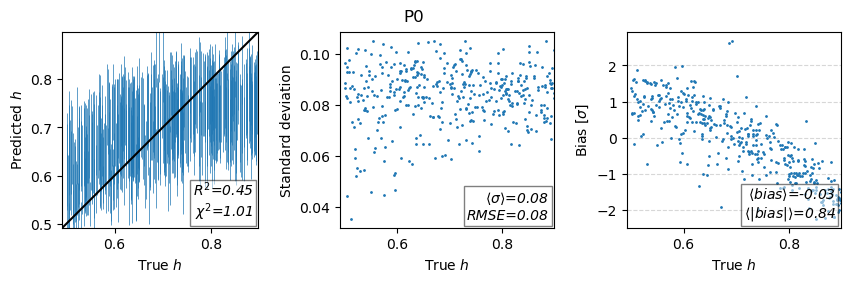

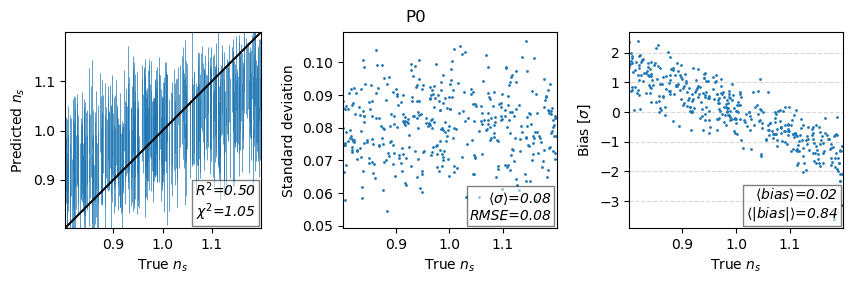

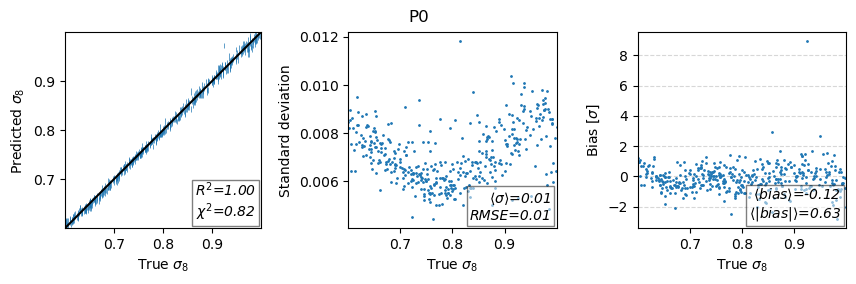

In [46]:
#
true_y = ((y_test * std_params) + mean_params).reset_index(drop=True).values
predict_y = ((y_mean_predict * std_params)  + mean_params).values
predict_E = (y_sigma_predict*std_params).values

for j in range(5):
    check_predictions(
        true_y[:,j],
        predict_y[:,j],
        predict_E[:,j],
        label=label_LaTeX_names_vanilla[j],
        title="P0")
